# Projeto "Maestro das Palavras": Ensinando uma IA a Entender Letras de Música 🎶

## A Missão: O Coração da Canção

Imagine uma inteligência artificial que não apenas lê palavras, mas *sente* o ritmo e a alma da linguagem, especialmente como ela flui nas letras de música. Esse é o nosso projeto! Estamos treinando um verdadeiro **"Maestro das Palavras"** digital.

A sua grande missão? Olhar para um trecho de uma música onde uma palavra foi escondida (`[mask]`) e, usando sua inteligência, adivinhar qual palavra se encaixa ali, como um músico que completa uma melodia inacabada.

## A Magia por Trás da Cortina: Transformers e Atenção 🧠✨

Como nosso Maestro aprende essa habilidade quase mágica? Ele usa uma arquitetura de rede neural revolucionária chamada **Transformer**.

Pense no Transformer como um ouvinte *extremamente* atento. Em vez de apenas olhar a palavra anterior ou seguinte, ele possui um mecanismo de **"Atenção"** que permite "ouvir" e ponderar a importância de **todas** as palavras na frase (ou até em frases próximas) ao mesmo tempo.

Isso é crucial para a música! Uma palavra no final de um verso pode depender totalmente de algo dito no início. O Transformer captura essas conexões, longas ou curtas, entendendo o **contexto** geral da letra, assim como entendemos o sentimento de uma estrofe inteira, não apenas de notas isoladas.

## O Método do Mestre: BERT e a Arte de Aprender 🎓

Nosso Maestro segue a filosofia de um "mestre" renomado no mundo da IA, conhecido como **BERT** (Bidirectional Encoder Representations from Transformers). O BERT popularizou uma forma genial de treinar esses Transformers para entender a linguagem profundamente.

A ideia chave do BERT é ser **bidirecional**: para entender uma palavra, olhe para o que vem *antes* E o que vem *depois* dela. É como ler uma partitura completa antes de tocar uma nota específica.

## O Treinamento: Completando as Lacunas (MLM) 📝

Como o Maestro pratica? Através de um exercício fundamental inspirado no BERT, chamado **Masked Language Modeling (MLM)** – Modelagem de Linguagem Mascarada. É exatamente isso que o nosso código faz!

1.  Pegamos uma letra de música do nosso "songbook" (os arquivos `.txt` em `musicas/`).
2.  **Mascaramos** aleatoriamente algumas palavras, substituindo-as por um token especial `[mask]`.
    * Exemplo: "Todo [mask] tem seu fim"
3.  **Desafiamos** o Maestro: "Ei, usando todo o seu conhecimento de contexto (via Transformer), adivinhe qual palavra original estava aqui onde está o `[mask]`!"

Ao forçar o modelo a prever essas palavras escondidas com base no contexto ao redor (bidirecionalmente), ele aprende representações ricas e profundas sobre como as palavras se relacionam em letras de música. Ele não está apenas decorando, está *compreendendo*.

## O Resultado: Um Vislumbre da Compreensão 🎤

Após treinar intensamente com milhares desses exemplos mascarados, nosso Maestro das Palavras se torna capaz de:

* Receber uma nova frase com `[mask]`.
* Analisar o contexto usando sua arquitetura Transformer.
* Prever as palavras mais prováveis para preencher a lacuna, demonstrando sua compreensão da linguagem lírica.

Este projeto, portanto, é a construção e o treinamento de um modelo Transformer, inspirado nos princípios do BERT e usando a tarefa de MLM, para desenvolver uma compreensão contextual profunda especificamente a partir de letras de música. É um passo fascinante na jornada para criar IAs que não apenas processem, mas talvez um dia, até *sintam* a arte da linguagem.

# Configuração Inicial e Importação de Bibliotecas

Este trecho de código realiza as configurações iniciais para o ambiente do notebook, definindo o backend do Keras e importando as bibliotecas necessárias para manipulação de dados, operações com matrizes, processamento de texto e construção de modelos. Além disso, cria uma classe de configuração (usando `@dataclass`) que contém parâmetros importantes como tamanho máximo de sequência, tamanho do lote, taxa de aprendizado, entre outros, facilitando a parametrização dos modelos.



In [51]:
import os

os.environ[ "KERAS_BACKEND" ] = "torch"

import keras_hub

import keras
from keras import layers
from keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

In [52]:
# Identificar se está usando a CPU ou GPU no PyTorch

import torch

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print( f"Using device: {device}" )

Using device: cuda


In [53]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 16  #32
    LR = 0.0001  #0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

# Leitura de Dados e Criação de DataFrames

Este trecho de código define funções que realizam a leitura de arquivos de texto de uma pasta específica, extraem o conteúdo dos arquivos e geram dataframes. A função `get_text_list_from_files` recebe uma lista de arquivos e retorna seus conteúdos como uma lista de strings. Em seguida, a função `get_data_from_text_files` utiliza essa lista para criar um dataframe onde cada linha corresponde ao conteúdo de um arquivo (letra de música). Por fim, os dataframes de treino e teste/validação são criados e seus tamanhos são exibidos.


In [54]:
def get_text_list_from_files( files ) -> list[ str ]:
    """
    Lê o conteúdo de múltiplos arquivos e retorna uma lista de strings,
    onde cada string representa o conteúdo de um arquivo.

    Args:
        files (list[str]): Uma lista contendo os caminhos dos arquivos a serem lidos.

    Returns:
        list[str]: Uma lista onde cada elemento é o conteúdo de um arquivo.
    """
    text_list: list[ str ] = [ ]
    for file_path in files:
        with open( file_path, "r", encoding = "utf-8" ) as file:
            # Lê todo o conteúdo do arquivo de uma vez.
            # Se o arquivo contiver várias linhas e você precisar de cada linha como um item separado na lista,
            # você pode iterar sobre o objeto 'file' (por exemplo, `for line in file: text_list.append(line.strip())`).
            text_list.append( file.read() )
    return text_list


def get_data_from_text_files( folder_name: str ) -> pd.DataFrame:
    """
    Busca arquivos de texto em uma pasta específica, lê seus conteúdos e
    retorna um DataFrame do pandas com uma coluna contendo o texto de cada arquivo.

    Args:
        folder_name (str): O nome da pasta onde os arquivos de texto estão localizados.
                           Espera-se que os arquivos estejam dentro de um subdiretório chamado 'musicas'.

    Returns:
        pd.DataFrame: Um DataFrame com uma coluna chamada 'lyric', onde cada linha
                      contém o texto de um arquivo. O DataFrame é embaralhado e o
                      índice é resetado.
    """

    # Utiliza a biblioteca glob para encontrar todos os arquivos com extensão .txt
    # dentro do subdiretório especificado dentro de 'musicas'.
    files = glob.glob( f"musicas/{folder_name}/*.txt" )

    # Chama a função auxiliar para obter uma lista contendo o texto de cada arquivo encontrado.
    texts: list[ str ] = get_text_list_from_files( files )

    # Cria um DataFrame do pandas com uma única coluna chamada 'lyric'.
    df = pd.DataFrame( { "lyric": texts } )

    # Embaralha as linhas do DataFrame para garantir uma ordem aleatória dos dados.
    # 'frac=1' indica que todas as linhas devem ser amostradas.
    df = df.sample( frac = 1 )

    # Reseta o índice do DataFrame.
    # 'drop=True' impede que o índice antigo seja adicionado como uma nova coluna.
    df = df.reset_index( drop = True )

    return df


# Cria o DataFrame de treino chamando a função com o nome da pasta 'train'.
train_df = get_data_from_text_files( "train" )

# Cria o DataFrame de teste/validação chamando a função com o nome da pasta 'test'.
test_df = get_data_from_text_files( "test" )

# Imprime o tamanho (número de linhas) do DataFrame de treino.
print( f"Tamanho do DataFrame de Treino: {len( train_df )}" )

# Imprime o tamanho (número de linhas) do DataFrame de teste/validação.
print( f"Tamanho do DataFrame de Teste/Validação: {len( test_df )}" )

Tamanho do DataFrame de Treino: 1444
Tamanho do DataFrame de Teste/Validação: 361


In [55]:
train_df.head()

,lyric
0,Ela vem pronta pro abate Novinha fica a vontad...
1,Meu pedaço de pecado De corpo colado Vem dança...
2,Lá vai a chalana Bem longe se vai Navegando no...
3,Eu não sei por que estou aqui Há uma chuva de ...
4,Já esperei meu prometeu No céu da terra se per...


# Pré-processamento e Vetorização de Texto com TensorFlow

Este trecho de código configura funções para pré-processamento e vetorização de textos utilizando o TensorFlow. Inicialmente, define-se uma função de normalização customizada para converter o texto em minúsculas, remover tags HTML e caracteres especiais. Em seguida, é criada uma camada `TextVectorization` do Keras, que é adaptada ao conjunto de textos de treino para transformar o texto em sequências numéricas, permitindo a criação e ajuste de um vocabulário customizado. Também é exemplificada a obtenção do ID de um token especial (`[mask]`) e a função `encode` para converter novos textos em arrays NumPy contendo suas respectivas sequências numéricas.


In [56]:
import tensorflow as tf


def custom_standardization( input_data ):
    """
    Função para realizar a normalização de texto. Esta função converte o texto
    para minúsculas, remove tags HTML e caracteres especiais.

    Args:
        input_data (tf.Tensor): Um tensor de string contendo o texto de entrada.

    Returns:
        tf.Tensor: Um tensor de string contendo o texto normalizado.
    """
    # Converter todas as letras do texto de entrada para minúsculas.
    lowercase = tf.strings.lower( input_data )

    # Utiliza uma expressão regular para remover todas as ocorrências da tag HTML "<br />"
    # e as substitui por um espaço em branco.
    stripped_html = tf.strings.regex_replace( lowercase, "<br />", " " )

    # Remove caracteres especiais do texto.
    # A expressão regular "[%s]" busca qualquer caractere dentro do conjunto especificado.
    # `re.escape()` é usado para garantir que os caracteres especiais na string de pontuação
    # sejam tratados literalmente na expressão regular.
    return tf.strings.regex_replace(
            stripped_html,
            "[%s]" % re.escape( "!#$%&'()*+,-./:;<=>?@\^_`{|}~" ),
            ""
    )

In [57]:
def get_vectorize_layer( texts: list[ str ], vocab_size: int, max_seq: int, special_tokens: list = [ "[MASK]" ]
                         ) -> TextVectorization:
    """
    Constrói e retorna uma camada de vetorização de texto (TextVectorization) do Keras.

    Esta camada converte uma lista de strings de texto em sequências de inteiros,
    onde cada inteiro corresponde a um token no vocabulário.

    Args:
        texts (list[str]): Uma lista de strings representando os textos de entrada
                           usados para adaptar a camada de vetorização.
        vocab_size (int): O tamanho máximo do vocabulário a ser criado. A camada
                          manterá os `vocab_size` tokens mais frequentes.
        max_seq (int): O comprimento máximo da sequência de saída. Sequências mais
                       longas serão truncadas e sequências mais curtas serão preenchidas
                       para atingir este comprimento.
        special_tokens (list[str], optional): Uma lista de tokens especiais que serão
                                                adicionados ao vocabulário. Por padrão,
                                                contém apenas o token '[MASK]'.

    Returns:
        TextVectorization: Uma camada de vetorização de texto do Keras configurada e adaptada.
    """

    # Cria uma instância da camada TextVectorization do Keras.
    vectorize_layer = TextVectorization(
            max_tokens = vocab_size,  # Define o número máximo de tokens no vocabulário.
            output_mode = "int",
            # Configura a saída para ser uma sequência de números inteiros (índices do vocabulário).
            standardize = custom_standardization,
            # Especifica a função de pré-processamento personalizada a ser aplicada ao texto.
            output_sequence_length = max_seq,  # Define o comprimento fixo para todas as sequências de saída.
    )

    # Adapta a camada de vetorização aos textos de entrada fornecidos.
    # Este processo calcula a frequência dos tokens nos textos e constrói o vocabulário.
    vectorize_layer.adapt( texts )

    # Obtém o vocabulário aprendido pela camada de vetorização.
    # O vocabulário é uma lista de strings, onde cada string é um token.
    vocab = vectorize_layer.get_vocabulary()

    # Por padrão, a camada TextVectorization adiciona dois tokens especiais ao início do vocabulário:
    # - "" (string vazia) com índice 0, usado para padding (preenchimento).
    # - "[UNK]" (token desconhecido) com índice 1, usado para palavras que não estão no vocabulário.

    # Esta seção ajusta o vocabulário para incluir os tokens especiais fornecidos pelo usuário
    # e remover os tokens padrão iniciais para liberar espaço.
    # - `vocab[2:]`: Seleciona todos os tokens a partir do terceiro elemento (índices 2 em diante),
    #                ignorando "" e "[UNK]".
    # - `vocab_size - len(special_tokens)`: Calcula quantos tokens do vocabulário original
    #                                      podem ser mantidos, considerando o espaço necessário
    #                                      para os tokens especiais.
    vocab = vocab[ 2: vocab_size - len( special_tokens ) ] + special_tokens

    # Define o vocabulário da camada de vetorização com o vocabulário modificado.
    # Isso garante que os tokens especiais sejam reconhecidos pela camada.
    vectorize_layer.set_vocabulary( vocab )

    # Retorna a camada de vetorização configurada.
    return vectorize_layer

In [58]:
# Extrai os valores da coluna 'lyric' do DataFrame de treino e os converte para uma lista.
train_texts = train_df.lyric.values.tolist()

# Cria a camada de vetorização de texto, utilizando apenas os textos de treinamento para adaptar o vocabulário.
vectorize_layer = get_vectorize_layer(
        train_texts,
        config.VOCAB_SIZE,
        config.MAX_LEN,
        special_tokens = [ "[mask]" ],
)

# Processamento de um novo dado: "[mask]"
# - Aplica a função de pré-processamento
# - Divide em token, pega seu id e cria uma sequência de comprimento config.MAX_LEN
# - Converte o resultado para um array NumPy
# - Pega o id do "[mask]"
mask_token_id = vectorize_layer( [ "[mask]" ] ).cpu().numpy()[ 0 ][ 0 ]

In [59]:
def encode( texts: list[ str ] ) -> tf.Tensor:
    """
    Converte uma lista de strings de texto em um array NumPy de sequências numéricas.

    Args:
        texts (list[str]): Uma lista de strings representando os textos de entrada a serem codificados.

    Returns:
        tf.Tensor: Um tensor do TensorFlow contendo as sequências numéricas correspondentes aos textos de entrada.
    """
    # Aplica a camada de vetorização aos textos de entrada para obter as sequências numéricas.
    encoded_texts = vectorize_layer( texts )
    # Retorna as sequências codificadas como um array NumPy.
    return encoded_texts.numpy()

# Geração de Dados Mascarados para Treinamento

Esta função, `get_masked_input_and_labels`, é responsável por preparar os dados para treinamento de modelos de linguagem que utilizam mascaramento, como os modelos de predição de tokens (por exemplo, BERT). Ela cria uma versão mascarada das sequências numéricas e gera os rótulos correspondentes, além de definir pesos para o cálculo da perda, de forma que apenas os tokens realmente mascarados contribuam para o treinamento.

**Resumo do Processo:**

- **Criação da Máscara Inicial:**
  Um array de booleanos (`inp_mask`) é criado, onde cada posição é selecionada com probabilidade de 15% para ser mascarada. Tokens especiais (com IDs menores ou iguais a 2) são excluídos do mascaramento.

- **Definição dos Rótulos:**
  Um array `labels` é inicializado com valor -1, indicando posições que não serão consideradas na perda. Em seguida, os IDs dos tokens selecionados pela máscara são copiados para `labels`, marcando os tokens a serem previstos.

- **Geração da Entrada Mascarada:**
  Uma cópia dos textos codificados é feita e, para 90% dos tokens inicialmente selecionados, os valores são substituídos pelo token de máscara (`mask_token_id`).

- **Substituição por Tokens Aleatórios:**
  Entre os tokens mascarados, 1/9 serão substituídos por tokens aleatórios (dentro de um intervalo específico), adicionando variabilidade à tarefa de predição.

- **Cálculo dos Pesos:**
  Um array de pesos (`sample_weights`) é criado para indicar que somente os tokens mascarados (diferentes de -1 nos labels) devem ser considerados no cálculo da perda.

- **Saída:**
  A função retorna a entrada modificada com tokens mascarados (`encoded_texts_masked`), os rótulos (`y_labels` que contêm os tokens originais) e os pesos amostrais para treinamento.


In [60]:
def get_masked_input_and_labels( encoded_texts ):
    """
    Cria as entradas mascaradas e os rótulos para a tarefa de Masked Language Modeling (MLM).

    Esta função recebe um array NumPy de textos codificados e realiza as seguintes etapas:
    1. Seleciona aleatoriamente uma pequena porcentagem dos tokens para mascarar.
    2. Garante que tokens especiais não sejam mascarados.
    3. Cria um array de rótulos contendo os IDs dos tokens originais que foram mascarados.
    4. Cria uma cópia dos textos codificados de entrada e aplica o mascaramento:
       - 90% dos tokens selecionados para mascaramento são substituídos pelo token de máscara (`mask_token_id`).
       - 10% dos tokens selecionados para mascaramento são substituídos por um token aleatório do vocabulário.
    5. Cria um array de pesos de amostra para garantir que a perda seja calculada apenas para os tokens mascarados.

    Args:
        encoded_texts (np.ndarray): Um array NumPy de inteiros representando os textos codificados.

    Returns:
        tuple: Uma tupla contendo três arrays NumPy:
            - encoded_texts_masked (np.ndarray): A versão da entrada com alguns tokens substituídos por [MASK] ou por tokens aleatórios.
            - y_labels (np.ndarray): Os tokens originais da entrada, que servem como os rótulos para o treinamento (apenas nas posições mascaradas).
            - sample_weights (np.ndarray): Um array de pesos que indica quais posições em `y_labels` devem ser consideradas no cálculo da perda.
    """
    # Cria um array booleano com a mesma forma de encoded_texts. Cada elemento será True com uma probabilidade de 0.15.
    # Isso indica as posições onde os tokens podem ser mascarados.
    inp_mask = np.random.rand( *encoded_texts.shape ) < 0.15

    # Garante que os tokens com IDs menores ou iguais a 2 (geralmente tokens especiais como padding ou desconhecido)
    # não sejam considerados para mascaramento. Define as posições correspondentes em inp_mask como False.
    inp_mask[ encoded_texts <= 2 ] = False

    # Inicializa um array com a mesma forma de encoded_texts preenchido com o valor -1.
    # Este array armazenará os rótulos para a tarefa de previsão. O valor -1 indica que o token naquela posição não é um alvo para previsão.
    labels = -1 * np.ones( encoded_texts.shape, dtype = int )

    # Para as posições onde inp_mask é True (ou seja, os tokens selecionados para mascaramento),
    # os valores dos IDs dos tokens originais (de encoded_texts) são atribuídos ao array de labels.
    # Assim, labels conterá os IDs dos tokens que foram mascarados, e o modelo aprenderá a prever esses IDs.
    labels[ inp_mask ] = encoded_texts[ inp_mask ]

    # Cria uma cópia do array encoded_texts original. Esta cópia será modificada para conter as entradas mascaradas.
    encoded_texts_masked = np.copy( encoded_texts )

    # Cria uma nova máscara booleana, inp_mask_2mask.
    # Ela será True apenas nas posições onde inp_mask também é True (o token foi selecionado para mascaramento)
    # E um novo número aleatório gerado para essa posição é menor que 0.9.
    # Isso significa que apenas 90% dos 15% dos tokens selecionados inicialmente para mascaramento serão, de fato, mascarados.
    inp_mask_2mask = inp_mask & (np.random.rand( *encoded_texts.shape ) < 0.90)

    # Nas posições onde inp_mask_2mask é True, o token correspondente em encoded_texts_masked é substituído pelo ID do token de máscara.
    encoded_texts_masked[ inp_mask_2mask ] = mask_token_id

    # Cria uma nova máscara booleana, inp_mask_2random.
    # Ela será True apenas nas posições onde inp_mask_2mask também é True (o token foi selecionado para ser mascarado)
    # E um novo número aleatório gerado para essa posição é menor que 1/9.
    # Isso significa que aproximadamente 1/9 dos 90% dos tokens que seriam mascarados serão, em vez disso, substituídos por um token aleatório.
    inp_mask_2random = inp_mask_2mask & (np.random.rand( *encoded_texts.shape ) < 1 / 9)

    # Nas posições onde inp_mask_2random é True, o token em encoded_texts_masked é substituído por um token aleatório.
    # np.random.randint(3, mask_token_id, inp_mask_2random.sum()) gera um array de números inteiros aleatórios
    # entre 3 (inclusive) e mask_token_id (exclusive). Começa em 3 porque as primeiras posições (0, 1, 2) geralmente
    # são reservadas para tokens especiais como padding e [UNK].
    encoded_texts_masked[ inp_mask_2random ] = np.random.randint(
            3, mask_token_id, inp_mask_2random.sum()
    )

    # Cria um array com a mesma forma de labels preenchido com o valor 1.
    # Este array será usado como pesos de amostra durante o treinamento.
    sample_weights = np.ones( labels.shape )

    # Nas posições onde o valor em labels é -1 (ou seja, os tokens não foram mascarados),
    # o valor correspondente em sample_weights é definido como 0.
    # Isso garante que a perda durante o treinamento seja calculada apenas para os tokens que foram realmente mascarados.
    sample_weights[ labels == -1 ] = 0

    # Cria uma cópia do array encoded_texts original. Este array representa os rótulos originais para cada token.
    y_labels = np.copy( encoded_texts )

    # Retorna uma tupla contendo:
    # - A entrada com alguns tokens substituídos por [MASK] ou tokens aleatórios.
    # - Os rótulos originais (para calcular a perda nos tokens mascarados).
    # - Os pesos de amostra para focar o treinamento nos tokens mascarados.
    return encoded_texts_masked, y_labels, sample_weights

# Preparação dos Dados para Treinamento de Modelo de Linguagem Mascarada

Esta seção codifica as letras em sequências numéricas, aplica o mascaramento necessário para a tarefa de predição de tokens e cria os datasets do TensorFlow para treinamento e validação. Com o mascaramento aplicado, os rótulos são definidos a partir dos tokens originais e os pesos são configurados de forma que apenas os tokens mascarados contribuam para a perda durante o treinamento.


In [61]:
# Codificação das letras
# Utiliza a função 'encode' para converter as letras (lyrics) do DataFrame de treino em sequências numéricas.
x_train = encode( train_df.lyric.values )
# Utiliza a função 'encode' para converter as letras (lyrics) do DataFrame de teste em sequências numéricas.
x_test = encode( test_df.lyric.values )

In [62]:
# Mascaramento das letras para a tarefa de Masked Language Modeling (MLM)
# Aplica a função 'get_masked_input_and_labels' aos dados de treino codificados para criar as entradas mascaradas,
# os rótulos (tokens originais) e os pesos de amostra para o treinamento.
x_train_masked, y_train_labels, train_sample_weights = get_masked_input_and_labels(
        x_train
)
# Aplica a função 'get_masked_input_and_labels' aos dados de teste codificados para criar as entradas mascaradas,
# os rótulos (tokens originais) e os pesos de amostra para a validação.
x_val_masked, y_val_labels, val_sample_weights = get_masked_input_and_labels(
        x_test
)

In [63]:
# Criação dos Datasets TensorFlow para otimizar o pipeline de dados

# Dataset de Treino para Masked Language Modeling (MLM)
# Cria um dataset TensorFlow a partir das fatias dos arrays NumPy: entradas mascaradas, rótulos e pesos de amostra do treino.
mlm_train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train_masked, y_train_labels, train_sample_weights)
)
# Configurações do dataset de treino:
# - shuffle(1000): Embaralha os elementos do dataset. Um buffer de 1000 elementos é usado para o embaralhamento.
# - batch(config.BATCH_SIZE): Agrupa os elementos do dataset em lotes do tamanho definido em 'config.BATCH_SIZE'.
# - prefetch(tf.data.AUTOTUNE): Permite que o dataset prepare os próximos lotes em segundo plano enquanto o lote atual está sendo processado, melhorando a performance.
mlm_train_ds = mlm_train_ds.shuffle( 1000 ).batch( config.BATCH_SIZE ).prefetch( tf.data.AUTOTUNE )

# Dataset de Teste (Validação) para Masked Language Modeling (MLM)
# Cria um dataset TensorFlow a partir das fatias dos arrays NumPy: entradas mascaradas, rótulos e pesos de amostra do teste/validação.
mlm_val_ds = tf.data.Dataset.from_tensor_slices(
        (x_val_masked, y_val_labels, val_sample_weights)
)
# Configurações do dataset de teste/validação:
# - batch(config.BATCH_SIZE): Agrupa os elementos do dataset em lotes do tamanho definido em 'config.BATCH_SIZE'.
# - prefetch(tf.data.AUTOTUNE): Permite que o dataset prepare os próximos lotes em segundo plano enquanto o lote atual está sendo processado, melhorando a performance.
# Observação: O dataset de teste/validação geralmente não é embaralhado, pois a ordem dos dados não deve influenciar a avaliação.
mlm_val_ds = mlm_val_ds.batch( config.BATCH_SIZE ).prefetch( tf.data.AUTOTUNE )

# Módulo BERT e Self-Attention

Este bloco define a função `bert_module`, que implementa uma camada Transformer com self-attention multi-cabeça e componentes feed-forward. A função inclui operações de dropout e normalização de camada para melhorar a regularização e estabilidade do treinamento, preparando a entrada para representações contextuais enriquecidas.


In [64]:
def bert_module( query, key, value, i ):
    """
    Implementa um bloco (módulo) do encoder Transformer, similar aos utilizados em modelos como o BERT.

    Este módulo realiza operações de multi-cabeças de autoatenção, dropout, normalização de camada e uma rede feed-forward.

    Args:
        query (tf.Tensor): Tensor de entrada representando a consulta (query) para a camada de atenção.
        key (tf.Tensor): Tensor de entrada representando a chave (key) para a camada de atenção.
        value (tf.Tensor): Tensor de entrada representando o valor (value) para a camada de atenção.
        i (int): Um índice para identificar este módulo específico do encoder (útil quando se tem múltiplas camadas).

    Returns:
        tf.Tensor: O tensor de saída deste módulo do encoder, com a mesma dimensão da entrada,
                   mas com representações contextuais aprimoradas.
    """

    # Camada de Multi-Cabeças de Autoatenção
    # A autoatenção permite que o modelo aprenda as relações entre as diferentes palavras em uma sequência,
    # ponderando a importância de cada palavra em relação às outras.
    # Utilizar múltiplas "cabeças" de atenção permite que o modelo capture diferentes tipos de relações
    # e foque em diferentes partes da sequência simultaneamente.
    attention_output = layers.MultiHeadAttention(
            num_heads = config.NUM_HEAD,  # Define o número de cabeças de atenção.
            key_dim = config.EMBED_DIM // config.NUM_HEAD,  # Define a dimensão de cada cabeça de atenção.
            name = f"encoder_{i}_multiheadattention",  # Nomeia a camada para fácil identificação.
    )( query, key, value )

    # Dropout para Regularização
    # O dropout é uma técnica de regularização que ajuda a prevenir o overfitting (sobreajuste)
    # ao desativar aleatoriamente uma proporção de neurônios durante o treinamento.
    attention_output = layers.Dropout( 0.1, name = f"encoder_{i}_att_dropout" )(
            attention_output
    )

    # Normalização de Camada (Layer Normalization) da Saída da Atenção
    # A normalização de camada é aplicada para estabilizar o processo de aprendizado e acelerar a convergência.
    # Ela normaliza as ativações dentro de cada amostra em um lote.
    # Aqui, a saída da atenção é adicionada à entrada original (query) antes da normalização,
    # uma técnica conhecida como "residual connection" (conexão residual), que ajuda no fluxo de informações.
    attention_output = layers.LayerNormalization(
            epsilon = 1e-6, name = f"encoder_{i}_att_layernormalization"
    )( query + attention_output )

    # Rede Feed-Forward (FFN)
    # A rede feed-forward é composta por duas camadas densas com uma função de ativação ReLU entre elas.
    # Ela serve para processar a saída da camada de atenção de forma não linear e capturar padrões mais complexos.
    ffn = keras.Sequential(
            [
                layers.Dense( config.FF_DIM, activation = "relu" ),
                # A primeira camada densa expande a dimensão para config.FF_DIM e aplica a ativação ReLU.
                layers.Dense( config.EMBED_DIM ),
                # A segunda camada densa projeta a saída de volta para a dimensão original (config.EMBED_DIM).
            ],
            name = f"encoder_{i}_ffn",  # Nomeia a rede feed-forward.
    )

    # Aplicação da Rede Feed-Forward
    ffn_output = ffn( attention_output )

    # Dropout após a Rede Feed-Forward para Regularização
    ffn_output = layers.Dropout( 0.1, name = f"encoder_{i}_ffn_dropout" )(
            ffn_output
    )

    # Normalização de Camada da Saída da Rede Feed-Forward
    # Similar à normalização aplicada após a atenção, aqui a saída da rede feed-forward é adicionada
    # à saída da camada de atenção (antes da FFN) através de uma conexão residual, e então normalizada.
    sequence_output = layers.LayerNormalization(
            epsilon = 1e-6, name = f"encoder_{i}_ffn_layernormalization"
    )( attention_output + ffn_output )

    # O resultado final (sequence_output) possui a mesma dimensionalidade da entrada (query),
    # mas as representações dos tokens foram enriquecidas com informações contextuais aprendidas
    # através das camadas de atenção e feed-forward.
    return sequence_output

# Função de Perda e Modelo de Linguagem Mascarada

Nesta seção, são definidos a função de perda (entropia cruzada esparsa) e o acompanhamento da perda usando métricas. Em seguida, é implementada a classe `MaskedLanguageModel`, que estende o `keras.Model` para customizar o cálculo da perda e métricas, permitindo um controle mais refinado durante o treinamento do modelo de linguagem mascarada.


In [65]:
# Função de perda de entropia cruzada esparsa
# Esta função de perda é apropriada para tarefas de classificação onde os rótulos (y) são fornecidos como índices inteiros (sparse labels).
# O parâmetro 'reduction = None' especifica que a perda não deve ser agregada (média ou soma) ao longo do lote.
# Isso fará com que a função de perda retorne um valor de perda para cada exemplo individual no lote.
loss_fn = keras.losses.SparseCategoricalCrossentropy( reduction = None )

# Objeto para rastrear a média dos valores de perda ao longo do treinamento (ou avaliação)
# 'keras.metrics.Mean' é uma classe que calcula a média de valores ao longo do tempo.
# Aqui, será usada para manter o controle da perda média durante cada época de treinamento.
loss_tracker = keras.metrics.Mean( name = "loss" )


# Classe customizada para o modelo de Masked Language Modeling (MLM)
# Esta classe herda de 'keras.Model' e permite definir o comportamento de perda e métricas de maneira personalizada,
# oferecendo maior controle sobre o processo de treinamento.
class MaskedLanguageModel( keras.Model ):

    # Método para calcular a perda durante o treinamento ou avaliação
    # 'x' representa as entradas, 'y' os rótulos verdadeiros, 'y_pred' as previsões do modelo
    # e 'sample_weight' os pesos das amostras (usados aqui para focar nos tokens mascarados).
    def compute_loss( self, x = None, y = None, y_pred = None, sample_weight = None ):
        # Como a função de perda 'loss_fn' foi inicializada com 'reduction = None', ela retorna um tensor
        # contendo um valor de perda para cada exemplo no lote.
        # Queremos que a perda total do lote seja o valor a ser otimizado, então somamos todas as perdas individuais.
        loss = loss_fn( y, y_pred, sample_weight )

        # Atualiza o estado do rastreador de perda ('loss_tracker') com os valores de perda do lote atual.
        # O parâmetro 'sample_weight' garante que a média da perda seja ponderada corretamente pelos tokens que foram mascarados.
        loss_tracker.update_state( loss, sample_weight = sample_weight )

        # Retorna a soma total das perdas do lote. Este valor será usado pelo otimizador para ajustar os pesos do modelo.
        return keras.ops.sum( loss )

    # Método para calcular as métricas durante o treinamento ou avaliação
    # Recebe as entradas, os rótulos verdadeiros, as previsões e os pesos das amostras.
    def compute_metrics( self, x, y, y_pred, sample_weight ):
        # Retorna um dicionário contendo as métricas a serem monitoradas.
        # Neste caso, estamos retornando apenas a perda média calculada pelo 'loss_tracker'.
        return { "loss": loss_tracker.result() }

    # Propriedade para listar os objetos de métrica do modelo
    # Este método é importante para que o Keras possa gerenciar o estado das métricas automaticamente.
    # Ao listar os objetos 'Metric' aqui, o método 'reset_states()' será chamado automaticamente no início de cada época
    # de treinamento ou no início da função 'evaluate()'.
    # Se esta propriedade não for implementada, seria necessário chamar 'reset_states()' manualmente.
    @property
    def metrics( self ):
        return [ loss_tracker ]

# Construção do Modelo BERT para Masked Language Modeling

Esta parte do notebook monta o modelo BERT adaptado para a tarefa de Masked Language Modeling (MLM). Inclui a definição das camadas de entrada, incorporação de tokens e posicional, aplicação dos blocos de Transformer (através do `bert_module`) e, por fim, a camada de classificação que gera as predições dos tokens mascarados. O modelo é compilado utilizando o otimizador Adam.


In [66]:
def create_masked_language_bert_model():
    """
    Cria um modelo BERT para a tarefa de Masked Language Modeling (MLM).

    Este modelo consiste em uma camada de embedding para as palavras, uma camada de embedding para as posições,
    múltiplos blocos Transformer (definidos na função `bert_module`) e uma camada de classificação para prever os tokens mascarados.

    Returns:
        MaskedLanguageModel: Uma instância do modelo BERT configurada para MLM.
    """
    # Define a camada de entrada do modelo.
    # Espera-se que a entrada seja uma sequência de tokens (IDs inteiros) com comprimento máximo definido em 'config.MAX_LEN'.
    inputs = layers.Input( (config.MAX_LEN,), dtype = "int64" )

    # Cria a camada de embedding de palavras (word embeddings).
    # Esta camada transforma cada ID de token em um vetor denso de tamanho 'config.EMBED_DIM',
    # representando a semântica da palavra.
    word_embeddings = layers.Embedding(
            config.VOCAB_SIZE, config.EMBED_DIM, name = "word_embedding"
    )( inputs )

    # Cria a camada de embedding de posição (position embeddings) usando a biblioteca TensorFlow Hub.
    # Em modelos Transformer, a ordem das palavras é importante. Essa camada adiciona informações sobre a posição de cada token na sequência.
    # 'sequence_length' define o comprimento máximo da sequência para o qual os embeddings de posição serão gerados.
    position_embeddings = keras_hub.layers.PositionEmbedding(
            sequence_length = config.MAX_LEN
    )( word_embeddings )

    # Combina as embeddings de palavras e as embeddings de posição.
    # A soma dessas duas embeddings fornece ao modelo informações sobre o significado da palavra e sua posição na frase.
    embeddings = word_embeddings + position_embeddings

    # Inicializa a saída do encoder com a combinação das embeddings.
    encoder_output = embeddings

    # Aplica múltiplos blocos Transformer (definidos na função 'bert_module').
    # O número de camadas (blocos) é definido em 'config.NUM_LAYERS'.
    # Cada bloco Transformer realiza autoatenção multi-cabeças e uma rede feed-forward.
    for i in range( config.NUM_LAYERS ):
        encoder_output = bert_module( encoder_output, encoder_output, encoder_output, i )

    # Cria a camada de classificação para a tarefa de Masked Language Modeling (MLM).
    # Esta camada densa projeta a saída do encoder de volta para o tamanho do vocabulário ('config.VOCAB_SIZE').
    # A função de ativação 'softmax' transforma as saídas brutas da rede em um vetor de probabilidades,
    # onde cada probabilidade representa a chance de um determinado token do vocabulário ser o token mascarado.
    mlm_output = layers.Dense( config.VOCAB_SIZE, name = "mlm_cls", activation = "softmax" )(
            encoder_output
    )

    # Cria uma instância do modelo MaskedLanguageModel que definimos anteriormente.
    # As entradas do modelo são as sequências de tokens ('inputs') e a saída é a previsão dos tokens mascarados ('mlm_output').
    mlm_model = MaskedLanguageModel( inputs, mlm_output, name = "masked_bert_model" )

    # Define o otimizador a ser usado para o treinamento.
    # 'Adam' é um algoritmo de otimização popular. A taxa de aprendizado ('learning_rate') é definida em 'config.LR'.
    optimizer = keras.optimizers.Adam( learning_rate = config.LR )

    # Compila o modelo, configurando o otimizador. A função de perda é definida dentro da classe MaskedLanguageModel.
    mlm_model.compile( optimizer = optimizer )

    # Retorna a instância do modelo BERT para MLM.
    return mlm_model


# Cria um mapeamento do ID do token para o token em si.
# 'vectorize_layer.get_vocabulary()' retorna uma lista de todos os tokens no vocabulário.
# 'enumerate' cria pares de índice e token, e 'dict()' transforma esses pares em um dicionário.
id2token = dict( enumerate( vectorize_layer.get_vocabulary() ) )

# Cria um mapeamento do token para o seu ID.
# Este dicionário é criado invertendo o dicionário 'id2token'. Para cada valor (token) em 'id2token',
# sua chave (ID) se torna o novo valor, e o token se torna a nova chave.
token2id = { y: x for x, y in id2token.items() }

# Mapeamento de Vocabulário e Callback de Geração de Texto

Neste trecho, é criado um mapeamento bidirecional entre IDs e tokens, facilitando a interpretação das sequências processadas. Também é definida a classe `MaskedTextGenerator`, um callback do Keras que, ao final de cada época, imprime exemplos de predições substituindo os tokens mascarados – auxiliando na visualização do desempenho do modelo durante o treinamento.


In [67]:
from tensorflow import keras
import numpy as np
from pprint import pprint
import torch  # Importa torch para verificar o tipo do tensor


# Por herdar de keras.callbacks.Callback, esta classe pode ser usada durante o treinamento
# para executar ações personalizadas ao final de cada época (ou em outros momentos do treinamento).
class MaskedTextGenerator( keras.callbacks.Callback ):
    def __init__( self, sample_tokens, top_k = 5 ):
        """
        Inicializa o gerador de texto mascarado.

        Args:
            sample_tokens (np.ndarray ou torch.Tensor): Um exemplo de sequência de tokens de entrada contendo o token de máscara.
            top_k (int, optional): O número de candidatos principais a serem considerados para cada posição mascarada. Defaults to 5.
        """
        self.sample_tokens = sample_tokens  # Exemplo de entrada que contém o token de máscara para previsão.
        self.k = top_k  # Número de candidatos principais (tokens com maior probabilidade) a serem considerados para substituir a máscara.

    # Converte uma sequência de IDs de tokens para uma string legível.
    def decode( self, tokens ):
        """
        Decodifica uma sequência de IDs de tokens para uma string.

        Args:
            tokens (np.ndarray): Um array NumPy de IDs de tokens.

        Returns:
            str: A string correspondente à sequência de tokens, com tokens desconhecidos representados por "[UNK]" e ignorando o token de padding (ID 0).
        """
        return " ".join( [ id2token.get( int( t ), "[UNK]" ) for t in tokens if t != 0 ] )

    # Converte um ID de token para seu token correspondente.
    def convert_ids_to_tokens( self, id ):
        """
        Converte um ID de token para o seu token correspondente usando o mapeamento id2token.

        Args:
            id (int): O ID do token.

        Returns:
            str: O token correspondente ao ID.
        """
        return id2token[ id ]

    # Este método é executado ao final de cada época de treinamento.
    def on_epoch_end( self, epoch, logs = None ):
        """
        Executa ações ao final de cada época de treinamento. Neste caso, gera e imprime as principais previsões para o token mascarado no exemplo de entrada.

        Args:
            epoch (int): O índice da época que acaba de terminar.
            logs (dict, optional): Um dicionário contendo as métricas de perda e outras informações registradas durante a época. Defaults to None.
        """
        # Obtém as previsões do modelo para o exemplo de entrada fornecido.
        # 'self.model' se refere ao modelo que está sendo treinado e que este callback está associado.
        prediction = self.model.predict( self.sample_tokens )

        # Procura o índice onde o token de máscara está presente na sequência de tokens de entrada.
        # 'np.where' retorna um array de índices onde a condição é verdadeira.
        # Como 'self.sample_tokens' pode ser um lote (mesmo que de tamanho 1), pegamos o índice dentro da sequência.
        masked_index = np.where( self.sample_tokens == mask_token_id )
        # 'masked_index' será uma tupla de arrays (para cada dimensão). Pegamos os índices da segunda dimensão (a sequência).
        masked_index = masked_index[ 1 ]

        # 'prediction' terá a mesma forma que a entrada, exceto que a última dimensão conterá as probabilidades
        # para cada token do vocabulário. Pegamos as probabilidades de predição para o token mascarado na sequência.
        mask_prediction = prediction[ 0 ][ masked_index ]

        # Para o token mascarado, obtemos os índices dos 'top_k' tokens com as maiores probabilidades.
        # 'argsort()' retorna os índices que ordenariam um array. Usamos '[-self.k:]' para pegar os últimos 'k' índices (maiores probabilidades)
        # e '[::-1]' para inverter a ordem, obtendo os índices em ordem decrescente de probabilidade.
        top_indices = mask_prediction[ 0 ].argsort()[ -self.k: ][ ::-1 ]
        # Obtemos os valores das probabilidades correspondentes aos 'top_indices'.
        values = mask_prediction[ 0 ][ top_indices ]

        # Itera sobre os 'top_k' candidatos previstos.
        for i in range( len( top_indices ) ):
            # Obtém o índice do token previsto.
            p = top_indices[ i ]
            # Obtém a probabilidade correspondente.
            v = values[ i ]

            # Cria uma cópia da sequência de tokens de entrada para não modificar a original.
            # Verifica se self.sample_tokens é um tensor do PyTorch e o move para a CPU se necessário.
            if isinstance( self.sample_tokens, torch.Tensor ):
                tokens = np.copy( self.sample_tokens[ 0 ].cpu().numpy() )
            else:
                tokens = np.copy( self.sample_tokens[ 0 ] )

            # Substitui o token de máscara na cópia da sequência pelo token previsto atual.
            tokens[ masked_index[ 0 ] ] = p

            # Cria um dicionário contendo o texto original, a previsão com o token substituído,
            # a probabilidade da previsão e o token previsto.
            result = {
                "input_text": self.decode( self.sample_tokens[ 0 ].cpu().numpy() ) if isinstance( self.sample_tokens,
                                                                                                  torch.Tensor
                                                                                                  ) else self.decode(
                        self.sample_tokens[ 0 ]
                ),
                "prediction": self.decode( tokens ),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens( p ),
            }
            # Imprime o resultado formatado para facilitar a leitura.
            pprint( result )

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add_6[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_6[0][0],      │
│                     │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 256, 128)  │          0 │ add_6[0][0],      │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

# Instanciação e Resumo do Modelo

Aqui são processados exemplos de entrada para teste do callback, a criação do modelo BERT para MLM com a função definida, e a visualização de seu resumo. Esse passo garante que a arquitetura do modelo esteja conforme o esperado antes de iniciar o treinamento.


In [ ]:
# Converte o exemplo de texto contendo a máscara para uma sequência de IDs de tokens
# utilizando a camada de vetorização ('vectorize_layer') que foi adaptada aos dados de treino.
sample_tokens = vectorize_layer( [ "Eu tenho [mask] " ] )

# Cria uma instância do callback MaskedTextGenerator, que será usado para gerar exemplos de predição
# ao final de cada época de treinamento.
# Verifica se 'sample_tokens' é um tensor do PyTorch. Se for, move-o para a CPU e o converte para um array NumPy
# antes de passá-lo para o callback, pois o callback espera um array NumPy ou similar.
if isinstance( sample_tokens, torch.Tensor ):
    generator_callback = MaskedTextGenerator( sample_tokens.cpu().numpy()
                                              )  # Movendo para a CPU e convertendo para numpy
else:
    generator_callback = MaskedTextGenerator( sample_tokens )

# Cria uma instância do modelo BERT para a tarefa de Masked Language Modeling (MLM)
# chamando a função 'create_masked_language_bert_model' que define a arquitetura do modelo.
bert_masked_model = create_masked_language_bert_model()

# Exibe um resumo da arquitetura do modelo BERT criado.
# O método 'summary()' mostra as camadas do modelo, suas formas de saída e o número de parâmetros treináveis e não treináveis.
# bert_masked_model.summary()

# Treinamento do Modelo

Esta seção configura os parâmetros de treinamento, incluindo o cálculo dos passos por época com base no tamanho dos dataframes de treino e validação. Em seguida, o modelo é treinado utilizando os datasets previamente criados, e o callback de geração de texto fornece feedback visual ao final de cada época.


In [68]:
# Calcula o número de passos (batches) por época para os conjuntos de treino e validação.
# O número de passos é determinado dividindo o número total de amostras pelo tamanho do lote (BATCH_SIZE).
# Usamos len(train_df) para obter o número de amostras no DataFrame de treino.
train_steps_per_epoch: int = len( train_df ) // config.BATCH_SIZE
# Usamos len(test_df) para obter o número de amostras no DataFrame de teste/validação.
val_steps_per_epoch: int = len( test_df ) // config.BATCH_SIZE

# Imprime o número calculado de passos por época para treino e validação.
print( f"Passos por época (Treino): {train_steps_per_epoch}" )
print( f"Passos por época (Validação): {val_steps_per_epoch}" )

# Inicia o treinamento do modelo BERT para Masked Language Modeling (MLM).
# O método 'fit' é usado para treinar o modelo com os dados de treinamento.
history = bert_masked_model.fit(
        # Dataset de treinamento para MLM, contendo as entradas mascaradas, rótulos e pesos.
        mlm_train_ds,
        validation_data = mlm_val_ds,
        # Dataset de validação para MLM, usado para avaliar o desempenho do modelo durante o treinamento.
        epochs = 5,
        # Define o número total de épocas (passagens completas pelos dados de treinamento) para treinar o modelo.
        steps_per_epoch = train_steps_per_epoch,
        # Especifica quantos passos de otimização devem ser realizados em cada época para o conjunto de treinamento.
        validation_steps = val_steps_per_epoch,
        # Especifica quantos passos de avaliação devem ser realizados em cada época para o conjunto de validação.
        callbacks = [ generator_callback ]
        # Passa uma lista de callbacks para serem executados em diferentes estágios do treinamento.
        # Aqui, 'generator_callback' será chamado ao final de cada época para gerar exemplos de predição.
)

Passos por época (Treino): 90
Passos por época (Validação): 22
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - loss: 10.3125

KeyboardInterrupt: 

# Salvamento do Modelo e Visualização dos Resultados

Após o treinamento, o modelo é salvo para uso futuro. Nesta etapa, também é gerado um gráfico que exibe a evolução da perda (tanto para treino quanto para validação) ao longo das épocas, permitindo a avaliação visual do desempenho do treinamento.


In [ ]:
# Salva o modelo BERT treinado para a tarefa de Masked Language Modeling (MLM) em um arquivo.
# O formato ".keras" é o formato padrão para salvar modelos no Keras 3.
bert_masked_model.save( "bert_mlm.keras" )

# Imprime uma mensagem indicando que o treinamento foi concluído e o modelo foi salvo com sucesso.
print( "\nTreinamento concluído e modelo salvo!" )


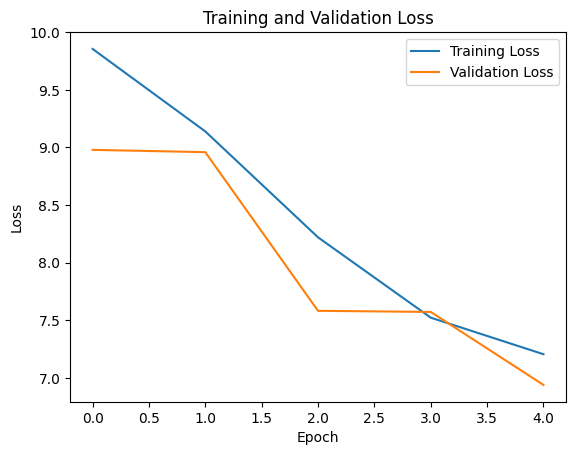

In [43]:
# Importa a biblioteca matplotlib.pyplot para criar gráficos.
import matplotlib.pyplot as plt

# Plota o histórico da perda (loss) durante o treinamento.
# 'history' é o objeto retornado pelo método 'fit' e contém informações sobre o treinamento, incluindo a perda em cada época.
# 'history.history['loss']' acessa a lista de valores da perda de treinamento em cada época.
plt.plot( history.history[ 'loss' ], label = 'Training Loss' )

# Plota o histórico da perda de validação durante o treinamento.
# No Keras, a perda calculada no conjunto de validação durante o treinamento é geralmente armazenada sob a chave 'val_loss' no dicionário 'history.history'.
plt.plot( history.history[ 'val_loss' ], label = 'Validation Loss' )
plt.title( 'Training and Validation Loss' )  # Define o título do gráfico.
plt.xlabel( 'Epoch' )  # Define o rótulo do eixo x como 'Epoch' (época).
plt.ylabel( 'Loss' )  # Define o rótulo do eixo y como 'Loss' (perda).
plt.legend()  # Exibe a legenda para identificar as linhas do gráfico (perda de treinamento e perda de validação).
plt.show()  # Exibe o gráfico gerado.

In [44]:
# Retoma o treinamento
from tensorflow.keras.models import load_model

# Carrega o modelo salvo
if 0:
    bert_mlm_model = load_model( "bert_mlm.keras" )
    bert_mlm_model.fit( mlm_ds.repeat(), epochs = 5, steps_per_epoch = steps, callbacks = [ generator_callback ] )

# Predição de Frases

Utilização do modelo treinado para realizar a predição de novas frases.

In [45]:
import pandas as pd
import numpy as np


# Função para prever o token mascarado e mostrar top K predições
def predict_masked_token( text_with_mask: str, model, vectorize_layer, id2token, top_k = 5 ):
    """
    Prevê o token mascarado em uma frase e retorna as top K previsões com probabilidades.

    Args:
        text_with_mask (str): A frase de entrada contendo exatamente um token '[mask]'.
        model (keras.Model): O modelo treinado (MLM).
        vectorize_layer (TextVectorization): A camada de vetorização JÁ ADAPTADA.
        id2token (dict): Dicionário mapeando ID para token.
        top_k (int): Quantidade de melhores previsões a serem mostradas.

    Returns:
        pandas.DataFrame: DataFrame com as top K previsões, tokens e probabilidades.
                         Retorna None se '[mask]' não for encontrado ou mais de um for encontrado.
    """
    # 1. Vetorizar a frase de entrada
    #    O reshape [1, -1] adiciona a dimensão do batch (lote de tamanho 1)
    sample_tokens = vectorize_layer( [ text_with_mask ] )  # Não precisa de .numpy() aqui para predict

    # Verifica se a vetorização retornou algo e se tem o formato esperado
    if sample_tokens is None or sample_tokens.shape[ 0 ] == 0:
        print( "Erro: A vetorização não produziu uma saída válida." )
        return None

    # 2. Encontrar o índice do token [mask]
    #    `.numpy()` converte o tensor para numpy array para usar np.where
    #    Pega o id do token de máscara global que definimos antes
    masked_index_tuple = np.where( sample_tokens.cpu().numpy()[ 0 ] == mask_token_id )

    # Verifica se encontrou o token de máscara e se é apenas um
    if len( masked_index_tuple[ 0 ] ) != 1:
        print(
                f"Erro: Esperado exatamente um token '[mask]' na frase vetorizada, mas encontrado(s) {len( masked_index_tuple[ 0 ] )}."
        )
        print( f"Frase vetorizada: {sample_tokens.numpy()[ 0 ]}" )
        print( f"ID esperado para [mask]: {mask_token_id}" )
        # Tenta decodificar para ajudar a depurar
        try:
            decoded_tokens = [ id2token.get( int( t ), "[UNK]" ) for t in sample_tokens.numpy()[ 0 ] if t != 0 ]
            print( f"Tokens decodificados: {' '.join( decoded_tokens )}" )
        except Exception as e:
            print( f"Não foi possível decodificar os tokens: {e}" )
        return None

    masked_index = masked_index_tuple[ 0 ][ 0 ]  # Pega o índice escalar

    # 3. Fazer a predição com o modelo
    prediction = model.predict( sample_tokens )

    # 4. Extrair as probabilidades para a posição mascarada
    #    prediction[0] -> batch de tamanho 1
    #    prediction[0][masked_index] -> probabilidades para o token na posição mascarada
    mask_prediction_probabilities = prediction[ 0 ][ masked_index ]

    # 5. Encontrar os top K índices e suas probabilidades
    #    argsort() retorna os índices que ordenariam o array (do menor para o maior)
    #    [-top_k:] pega os K maiores índices
    #    [::-1] inverte para ter do maior para o menor
    top_indices = mask_prediction_probabilities.argsort()[ -top_k: ][ ::-1 ]
    top_probabilities = mask_prediction_probabilities[ top_indices ]

    # 6. Converter os IDs dos tokens previstos para palavras
    top_tokens = [ id2token.get( idx, "[UNK]" ) for idx in top_indices ]

    # 7. Criar e retornar um DataFrame com os resultados
    results_df = pd.DataFrame( {
        "Token Previsto": top_tokens,
        "Probabilidade": top_probabilities
    }
    )

    print( f"\nPredições para: '{text_with_mask}'" )
    return results_df

In [50]:
frase_teste_1 = "Pra sempre com [mask]"
resultados_df_1 = predict_masked_token( frase_teste_1, bert_masked_model, vectorize_layer, id2token, top_k = 10 )

if resultados_df_1 is not None:
    print( resultados_df_1.to_string( index = False ) )  # .to_string para melhor formatação no print

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Predições para: 'Pra sempre com [mask]'
Token Previsto  Probabilidade
           não       0.010693
            de       0.010530
            eu       0.010237
             o       0.009339
             e       0.008349
          você       0.007479
            me       0.007308
             a       0.007162
           pra       0.007002
           meu       0.006103
